# Implementation of matchmaking algorithms

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
from itertools import combinations
import random
from sklearn.cluster import AgglomerativeClustering
import math

## Import data and divide into grade pools

In [203]:
# ========================= Input data for clustering ================================

sample_data = pd.read_csv('./Data/final_data_with_grade.csv')
a_data = sample_data[sample_data['grade'] == "A"]
b_data = sample_data[sample_data['grade'] == "B"]
c_data = sample_data[sample_data['grade'] == "C"]
d_data = sample_data[sample_data['grade'] == "D"]
e_data = sample_data[sample_data['grade'] == "E"]
f_data = sample_data[sample_data['grade'] == "F"]
g_data = sample_data[sample_data['grade'] == "G"]

# only consider multiple of 10 players
a_data = a_data[9:]
b_data = b_data[8:]
c_data = c_data[1:]
d_data = d_data[1:]
e_data = e_data[5:]
f_data = f_data[6:]
g_data = g_data[7:]

a_data = a_data.reset_index(drop=True)
b_data = b_data.reset_index(drop=True)
c_data = c_data.reset_index(drop=True)
d_data = d_data.reset_index(drop=True)
e_data = e_data.reset_index(drop=True)
f_data = f_data.reset_index(drop=True)
g_data = g_data.reset_index(drop=True)

batches = [a_data, b_data, c_data, d_data, e_data, f_data, g_data]
bcf_batches = [b_data, c_data, f_data]
c_batch = [c_data]

## Fairness Functions

In [175]:
# ======================= Fariness fucntions ================================
def rate_player(player_id):
    final_dataset = sample_data
    r_BP = final_dataset[final_dataset['idPlayer'] == player_id]["brilliantPerformance"]
    r_WHR = final_dataset[final_dataset['idPlayer'] == player_id]["weightedHitRate"]
    r_OP = final_dataset[final_dataset['idPlayer'] == player_id]["overallPerformance"]
    return (0.5 * r_OP + 0.35 * r_BP + 0.15 * r_WHR).to_numpy()[0]


# parameter r: an array containing 5 player rates in the team, in ascending order
def rate_team(r):
    return 0.35 * r[4] + 0.2 * r[0] + 0.15 * (r[1] + r[2] + r[3])

# parameter: t_1 and t_2 are array containing 5 player ratings in the team, in ascending order
def rate_match(t_1, t_2):
    return abs(rate_team(t_1) - rate_team(t_2))

# lm is an array of length 10, indicating 10 players in one game
def team_match(lm):
    player_rate = []
    for i in lm:
        player_rate.append(rate_player(i))
    player_rate.sort()
    combs = combinations(player_rate, 5)
    local_match_fairness = 100
    for c in combs:
        t_1 = list(c)
        t_2 = [i for i in player_rate if i not in t_1]
        match_score = rate_match(t_1, t_2)
        if (match_score < local_match_fairness):
            local_match_fairness = match_score
    return local_match_fairness
        

# M is the global matchmaking result
def rate_matchmaking(M):
    all_game_fairness = []
    global_fairness = 0
    for i in M.values():
        local_match_fairness = team_match(i)
        all_game_fairness.append(local_match_fairness)
        if (local_match_fairness > global_fairness):
            global_fairness = local_match_fairness
    return global_fairness, all_game_fairness

# x = [1,2,3,4,5,6,7,8,9,10]
# print(team_match(x))


## Alg1: k-means Algorithm

In [176]:
# # ========================= Kmeans ===========================

# parameter: player_data is a dataframe
def KMeans_matchmaking(player_data, cluster_size=10):
    player_data = player_data.reset_index(drop=True)
    feature_data = player_data.drop(['grade', 'idPlayer'],axis=1)
    c_data = feature_data.to_numpy()

    n_clusters = len(c_data) // cluster_size
    kmeans = KMeans(n_clusters=n_clusters).fit(c_data)

    # Re-assign data points to clusters to ensure that each cluster has the desired size
    labels = kmeans.labels_
    cluster_counts = np.bincount(labels)

    for i in range(len(cluster_counts)):
        while cluster_counts[i] > cluster_size:
            # Find the data point farthest from the centroid of the current cluster
            distances = np.linalg.norm(c_data[kmeans.labels_ == i] - kmeans.cluster_centers_[i], axis=1)
            farthest_point_index = np.argmax(distances)

            original_index = 0
            cur = -1
            for j in range(len(labels)):
                if labels[j] == i:
                    cur += 1
                    if (cur == farthest_point_index):
                        original_index = j
                        break

            # Assign the farthest point to the nearest underfull cluster
            underfull_clusters = np.where(cluster_counts < cluster_size)[0]
            distances_to_underfull_clusters = np.linalg.norm(c_data[underfull_clusters] - c_data[kmeans.labels_ == i][farthest_point_index], axis=1)
            nearest_underfull_cluster = underfull_clusters[np.argmin(distances_to_underfull_clusters)]
            labels[original_index] = nearest_underfull_cluster
            
            # Update the cluster counts
            cluster_counts[i] -= 1
            cluster_counts[nearest_underfull_cluster] += 1

    def retrive_idPlayer(index):
        return player_data.loc[index]["idPlayer"]

    global_match = {}
    for i in range(max(labels) + 1):
        global_match[str(i)] = []
        
    for i in range(len(labels)):
        global_match[str(labels[i])].append(retrive_idPlayer(i))

    return global_match

# test = KMeans_matchmaking(c_data)
# print(test)

## K-means: Generate Matchmaking Data

In [177]:
# ============================= Results ===================================
def run_Kmeans_one_pool(pool):
    Kmeans_match_results = []
    global_match = KMeans_matchmaking(pool)
    # find optimum team assignements in each game, report the final fairness
    global_fairness, all_fairness = rate_matchmaking(global_match)
    Kmeans_match_results.append(global_fairness)
    Kmeans_match_results.append(all_fairness)
    return Kmeans_match_results

def run_Kmeans_one_pool_multiple_times(pool, times):
    Kmeans_match_results = []
    for i in range(times):
        temp = run_Kmeans_one_pool(pool)
        Kmeans_match_results.append(temp)
    return Kmeans_match_results

def run_Kmeans_all_pool_multiple_times(pools, times):
    Kmeans_match_results = {}
    for i in range(len(pools)):
        data = pools[i]
        temp = run_Kmeans_one_pool_multiple_times(data, times)
        Kmeans_match_results[str(i)] = temp
    return Kmeans_match_results


# Kmeans_all_1_time = run_Kmeans_all_pool_multiple_times(batches, 1)
# Kmeans_bcd_1_time = run_Kmeans_all_pool_multiple_times(bcf_batches, 1)
kmeans_c_result_1_time = run_Kmeans_one_pool_multiple_times(c_data, 1)
kmeans_c_result_10_time = run_Kmeans_one_pool_multiple_times(c_data, 10)
kmeans_c_result_20_time = run_Kmeans_one_pool_multiple_times(c_data, 20)
kmeans_c_result_50_time = run_Kmeans_one_pool_multiple_times(c_data, 50)
kmeans_c_result_100_time = run_Kmeans_one_pool_multiple_times(c_data, 100)



## K-means: Visulization of Results

In [178]:
def generate_historgram_of_all_pools(results, method):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(36,12))
    
    b_dis = results['0'][0][1]
    c_dis = results['1'][0][1]
    f_dis = results['2'][0][1]

    axs[0].hist(b_dis, bins=50)
    axs[0].set_title('Fairness distribution in Grade B')
    axs[0].set_xlabel('Fairness')

    axs[1].hist(c_dis, bins=50)
    axs[1].set_title('Fairness distribution in Grade C')
    axs[1].set_xlabel('Fairness')

    axs[2].hist(f_dis, bins=50)
    axs[2].set_title('Fairness distribution in Grade F')
    axs[2].set_xlabel('Fairness')

    fig.tight_layout()
    # fig.suptitle('Fairness Distribution using Kmeans', fontsize=16)
    # plt.subplots_adjust(top=0.5)
    plt.savefig('./Results/Ditribution of game fairness in pools CDF ' + '(' + method +')', dpi=500, bbox_inches='tight', facecolor='white')

def comparision_bar_chart_between_all_methods(all_1_time):
    print("TBC")


# generate_historgram_of_all_pools(Kmeans_bcd_1_time, "K-means")

## Alg2: Agglomerative clustering (AGG)

In [179]:
# # ========================= Kmeans ===========================

# parameter: player_data is a dataframe
def Agg_matchmaking(player_data, cluster_size=10):
    player_data = player_data.reset_index(drop=True)
    feature_data = player_data.drop(['grade', 'idPlayer'],axis=1)
    c_data = feature_data.to_numpy()

    n_clusters = len(c_data) // cluster_size

    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(c_data)
    cluster_counts = np.bincount(labels)

    overfull_clusters = []
    underfull_clusters = []
    unchosen_indices = np.array([], dtype=int)

    for i in range(len(cluster_counts)):
        if cluster_counts[i] > cluster_size:
            overfull_clusters.append(i)
        elif cluster_counts[i] < cluster_size:
            underfull_clusters.append(i)

    # If the cluster has more than 10 points, randomly sample 10 points
    for i in overfull_clusters:
        cluster_indices = np.where(labels == i)[0]
        np.random.shuffle(cluster_indices)
        chosen_indices = cluster_indices[:cluster_size]
        temp_unchosen_indices = cluster_indices[cluster_size:]
        unchosen_indices = np.concatenate((unchosen_indices, temp_unchosen_indices), dtype=int)
        labels[chosen_indices] = i

    # If the cluster has fewer than 10 points, add random points to it
    for i in underfull_clusters:
            num_missing_points = cluster_size - cluster_counts[i]
            moved_indices = unchosen_indices[:num_missing_points]
            unchosen_indices = unchosen_indices[num_missing_points:]
            labels[moved_indices] = i

    def retrive_idPlayer(index):
        return player_data.loc[index]["idPlayer"]

    global_match = {}
    for i in range(max(labels) + 1):
        global_match[str(i)] = []
        
    for i in range(len(labels)):
        global_match[str(labels[i])].append(retrive_idPlayer(i))

    return global_match

# test = Agg_matchmaking(c_data)
# print(test)


## Agg: Generating Matchmaking Results

In [180]:
# ============================= Results ===================================
def run_Agg_one_pool(pool):
    Agg_match_results = []
    global_match = Agg_matchmaking(pool)
    # find optimum team assignements in each game, report the final fairness
    global_fairness, all_fairness = rate_matchmaking(global_match)
    Agg_match_results.append(global_fairness)
    Agg_match_results.append(all_fairness)
    return Agg_match_results

def run_Agg_one_pool_multiple_times(pool, times):
    Agg_match_results = []
    for j in range(times):
        temp = run_Agg_one_pool(pool)
        Agg_match_results.append(temp)
    return Agg_match_results

def run_Agg_all_pool_multiple_times(pools, times):
    Agg_match_results = {}
    for i in range(len(pools)):
        data = pools[i]
        temp = run_Agg_one_pool_multiple_times(data, times)
        Agg_match_results[str(i)] = temp
    return Agg_match_results


Agg_all_1_time = run_Agg_all_pool_multiple_times(batches, 1)
Agg_bcd_1_time = run_Agg_all_pool_multiple_times(bcf_batches, 1)

Agg_c_result_1_time = run_Agg_one_pool_multiple_times(c_data, 1)
Agg_c_result_10_time = run_Agg_one_pool_multiple_times(c_data, 10)
Agg_c_result_20_time = run_Agg_one_pool_multiple_times(c_data, 20)
Agg_c_result_50_time = run_Agg_one_pool_multiple_times(c_data, 50)
Agg_c_result_100_time = run_Agg_one_pool_multiple_times(c_data, 100)

## Agg: Visulization of Results

In [181]:
def generate_historgram_of_all_pools(results, method):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(36,12))
    
    b_dis = results['0'][0][1]
    c_dis = results['1'][0][1]
    f_dis = results['2'][0][1]

    axs[0].hist(b_dis, bins=50)
    axs[0].set_title('Fairness distribution in Grade B')
    axs[0].set_xlabel('Fairness')

    axs[1].hist(c_dis, bins=50)
    axs[1].set_title('Fairness distribution in Grade C')
    axs[1].set_xlabel('Fairness')

    axs[2].hist(f_dis, bins=50)
    axs[2].set_title('Fairness distribution in Grade F')
    axs[2].set_xlabel('Fairness')

    fig.tight_layout()
    # fig.suptitle('Fairness Distribution using Kmeans', fontsize=16)
    # plt.subplots_adjust(top=0.5)
    plt.savefig('./Results/Ditribution of game fairness in pools CDF ' + '(' + method +')', dpi=500, bbox_inches='tight', facecolor='white')

# generate_historgram_of_all_pools(Agg_bcd_1_time, "AGG")

# Alg3: BKPP

## 3.1 Import Data

In [182]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
sample_data = pd.read_csv('./Data/final_data_with_grade.csv')

sample_data_a = sample_data[sample_data['grade'] == "A"]
sample_data_a = sample_data_a[1:]
sample_data_a = sample_data_a.reset_index(drop=True)
#get the data structure we want
a_data = sample_data_a.drop('grade',axis=1)
a_data = a_data.drop('idPlayer',axis=1)
a_data = a_data[8:]
#print(a_data)
a_data = a_data.to_numpy()

sample_data_b = sample_data[sample_data['grade'] == "B"]
sample_data_b = sample_data_b[8:]
sample_data_b = sample_data_b.reset_index(drop=True)
#get the data structure we want
b_data = sample_data_b.drop('grade',axis=1)
b_data = b_data.drop('idPlayer',axis=1)
b_data = b_data.to_numpy()

sample_data_c = sample_data[sample_data['grade'] == "C"]
sample_data_c = sample_data_c[1:]
sample_data_c = sample_data_c.reset_index(drop=True)
#get the data structure we want
c_data = sample_data_c.drop('grade',axis=1)
c_data = c_data.drop('idPlayer',axis=1)
c_data = c_data.to_numpy()

sample_data_d = sample_data[sample_data['grade'] == "D"]
sample_data_d = sample_data_d[1:]
sample_data_d = sample_data_d.reset_index(drop=True)
#get the data structure we want
d_data = sample_data_d.drop('grade',axis=1)
d_data = d_data.drop('idPlayer',axis=1)
d_data = d_data.to_numpy()

sample_data_e = sample_data[sample_data['grade'] == "E"]
sample_data_e = sample_data_e[5:]
sample_data_e = sample_data_e.reset_index(drop=True)
#get the data structure we want
e_data = sample_data_e.drop('grade',axis=1)
e_data = e_data.drop('idPlayer',axis=1)
e_data = e_data.to_numpy()

sample_data_f = sample_data[sample_data['grade'] == "F"]
sample_data_f = sample_data_f[6:]
sample_data_f = sample_data_f.reset_index(drop=True)
#get the data structure we want
f_data = sample_data_f.drop('grade',axis=1)
f_data = f_data.drop('idPlayer',axis=1)
f_data = f_data.to_numpy()

sample_data_g = sample_data[sample_data['grade'] == "G"]
sample_data_g = sample_data_g[7:]
sample_data_g = sample_data_g.reset_index(drop=True)
#get the data structure we want
g_data = sample_data_g.drop('grade',axis=1)
g_data = g_data.drop('idPlayer',axis=1)
g_data = g_data.to_numpy()

cluster_size = 10 #number players in each cluster
num_clusters = len(c_data) // cluster_size  #nuber of clusters.


def retrive_idPlayer(index):
    return sample_data.loc[index]["idPlayer"]

## Alg3: BKPP Funtion

In [183]:
%%capture --no-display
cluster_size = 10 #number players in each cluster
#num_clusters = len(c_data) // cluster_size  #nuber of clusters.

def balanced_kmeans(X, n_clusters, n_init=10):  
    # Initialize the first centroid randomly
    num_clusters = len(X) // cluster_size
    n_clusters = num_clusters
    centroids = [X[np.random.randint(X.shape[0])]]
    
    # Calculate the remaining centroids using the k-means++ algorithm
    for i in range(1, n_clusters):
        distances = np.array([np.min([np.linalg.norm(x - c) for c in centroids]) for x in X])
        probabilities = distances / np.sum(distances)
        centroid_idx = np.random.choice(X.shape[0], p=probabilities)
        centroids.append(X[centroid_idx])
        
    # Initialize the clusters
    clusters = [[] for _ in range(n_clusters)]
    
    # Perform k-means clustering with multiple initializations
    best_score = float('inf')
    for _ in range(n_init):
        kmeans = KMeans(n_clusters=n_clusters, init=np.array(centroids))
        labels = kmeans.fit_predict(X)
        score = kmeans.inertia_
        
        # If the score is better than previous iterations, save the labels
        if score < best_score:
            best_labels = labels
            best_score = score
            
    # Assign the data points to the clusters
    for i, label in enumerate(best_labels):
        clusters[label].append(X[i])
        
    # Balance the clusters by randomly removing data points from the larger clusters
    max_size = max(len(cluster) for cluster in clusters)
    for cluster in clusters:
        if len(cluster) < max_size:
            diff = max_size - len(cluster)
            idxs = np.random.choice(len(cluster), size=diff)
            cluster = [cluster[i] for i in range(len(cluster)) if i not in idxs]

    counter = 0  #用于计算总共经过了多少次迁移
    # print(counter, " L- ", labels)   #打印初始的标签
    cluster_counts = np.bincount(labels)
    # print(counter, " C- ", np.bincount(labels))

    for i in range(len(cluster_counts)):  #对每个标签遍历一遍
        while cluster_counts[i] > cluster_size:   #move data from clusters that have more than desired number
            # print('\n')
            counter += 1
            # Find the data point farthest from the centroid of the current cluster
            distances = np.linalg.norm(X[kmeans.labels_ == i] - kmeans.cluster_centers_[i], axis=1)  #得到距离（norm）

            #print(counter, "distance", distances)

            farthest_point_index = np.argmax(distances)  #从距离里面找到最大值，得到对应的index

            original_index = 0
            cur = -1
            for j in range(len(labels)):  #遍历每个label
                if labels[j] == i:   #找到现在所在的label
                    cur += 1    
                    if (cur == farthest_point_index):
                        original_index = j
                        break
            # Assign the farthest point to the nearest underfull cluster这里面最远的点表示离这个中心最远的点
            underfull_clusters = np.where(cluster_counts < cluster_size)[0]
            distances_to_underfull_clusters = np.linalg.norm(X[underfull_clusters] - X[kmeans.labels_ == i][farthest_point_index], axis=1)
            nearest_underfull_cluster = underfull_clusters[np.argmin(distances_to_underfull_clusters)]
            #labels[kmeans.labels_ == i][farthest_point_index] = nearest_underfull_cluster


            #print(counter, "before label to be replaced", labels[kmeans.labels_ == i][farthest_point_index], labels[original_index])
            labels[original_index] = nearest_underfull_cluster
            #print the label of each data


            #print(counter, " L- ", labels)  #现在所有的data对应的label
            #print(counter, "label replaced by", nearest_underfull_cluster)  #被迁移的点被迁移到了哪个label
            #print(counter, "after label to be replaced", labels[kmeans.labels_ == i][farthest_point_index], labels[original_index])  #表示是从哪个label向哪个迁移过去的


            # Update the cluster counts
            cluster_counts[i] -= 1
            cluster_counts[nearest_underfull_cluster] += 1
            # print(counter, " C- ", np.bincount(labels))  #每个label这一轮之后的各标签计数
            # print(cluster_counts)
            #print(labels)
    def retrive_idPlayer(index):
        return sample_data.loc[index]["idPlayer"]
    global_match = {}
    for i in range(len(cluster_counts)):
        global_match[str(i)] = []
    for i in range(len(cluster_counts)):
        for j in range(len(labels)):
            if labels[j] == i:
                #global_match[str(cluster_counts[i])].append(retrive_idPlayer(i)) #这样不管怎么样，最后都是放到簇10里面
                global_match[str(i)].append(retrive_idPlayer(j))
    return global_match

## BKPP: Generate matcmaking result

In [184]:
%%capture --no-display
sample_data = pd.read_csv('./Data/final_data_with_grade.csv')
sample_data = sample_data[sample_data['grade'] == "C"]
sample_data = sample_data[1:]
sample_data = sample_data.reset_index(drop=True)
#get the data structure we want
c_data = sample_data.drop('grade',axis=1)
c_data = c_data.drop('idPlayer',axis=1)
c_data = c_data.to_numpy()
cluster_size = 10 #number players in each cluster
num_clusters = len(c_data) // cluster_size  #nuber of clusters.

BKPP_AF_100_times = []
BKPP_GF_100_times = []

for i in range(100):
    clusters = balanced_kmeans(X=c_data, n_clusters=num_clusters)  # Perform balanced k-means++ clustering
    global_fairness, all_fairness = rate_matchmaking(clusters)
    BKPP_AF_100_times.append(all_fairness)
    BKPP_GF_100_times.append(global_fairness)


# Visuliaztion of all three Methods

## Data Preparation

In [185]:
# Separate all the data in terms of GF and AF

# print(Agg_c_result_100_time)
# print(kmeans_c_result_100_time)
# print(BKPP_AF_100_times)
# print(BKPP_GF_100_times)

# Agg_AF_100_times = []
# Agg_GF_100_times = []
# Kmeans_AF_100_times = []
# Kmeans_GF_100_times = []
# for i in range(100):
#     Kmeans_GF_100_times.append(kmeans_c_result_100_time[i][0])
#     Kmeans_AF_100_times.append(kmeans_c_result_100_time[i][1])
#     Agg_GF_100_times.append(Agg_c_result_100_time[i][0])
#     Agg_AF_100_times.append(Agg_c_result_100_time[i][1])

# np.savetxt('Kmeans_AF.txt', Kmeans_AF_100_times)
# np.savetxt('kmeans_GF.txt', Kmeans_GF_100_times)
# np.savetxt('AGG_AF.txt', Agg_AF_100_times)
# np.savetxt('AGG_GF.txt', Agg_GF_100_times)
# np.savetxt('BKPP_AF.txt', BKPP_AF_100_times)
# np.savetxt('BKPP_GF.txt', BKPP_GF_100_times)

Kmeans_GF = []  # hist & qq-plot
Kmeans_AF = []  # hist & qq-plot
Kmeans_SBGF_Var = [] # hist & qq-plot
for i in range(100):
    Kmeans_GF.append(kmeans_c_result_100_time[i][0])
    Kmeans_AF.append(np.mean(kmeans_c_result_100_time[i][1]))
    Kmeans_SBGF_Var.append(np.var(kmeans_c_result_100_time[i][1]))
Kmeans_GF_Var = np.var(Kmeans_GF)   # bar
Kmeans_overall_max = max(Kmeans_GF) # bar
Kmeans_overall_mean = np.mean(Kmeans_GF) # bar

Agg_GF = []  # hist & qq-plot
Agg_AF = []  # hist & qq-plot
Agg_SBGF_Var = [] # hist & qq-plot
for i in range(100):
    Agg_GF.append(Agg_c_result_100_time[i][0])
    Agg_AF.append(np.mean(Agg_c_result_100_time[i][1]))
    Agg_SBGF_Var.append(np.var(Agg_c_result_100_time[i][1]))
Agg_GF_Var = np.var(Agg_GF)   # bar
Agg_overall_max = max(Agg_GF) # bar
Agg_overall_mean = np.mean(Agg_GF) # bar


BKPP_GF = [] # hist & qq-plot
BKPP_AF = [] # hist & qq-plot
BKPP_SBGF_Var = [] # hist & qq-plot
for i in range(100):
    BKPP_GF.append(BKPP_GF_100_times[i])
    BKPP_AF.append(np.mean(BKPP_AF_100_times[i]))
    BKPP_SBGF_Var.append(np.var(BKPP_AF_100_times[i]))
BKPP_GF_Var = np.var(BKPP_GF)   # bar
BKPP_overall_max = max(BKPP_GF) # bar
BKPP_overall_mean = np.mean(BKPP_GF) # bar



## Historgram of attributes of each method

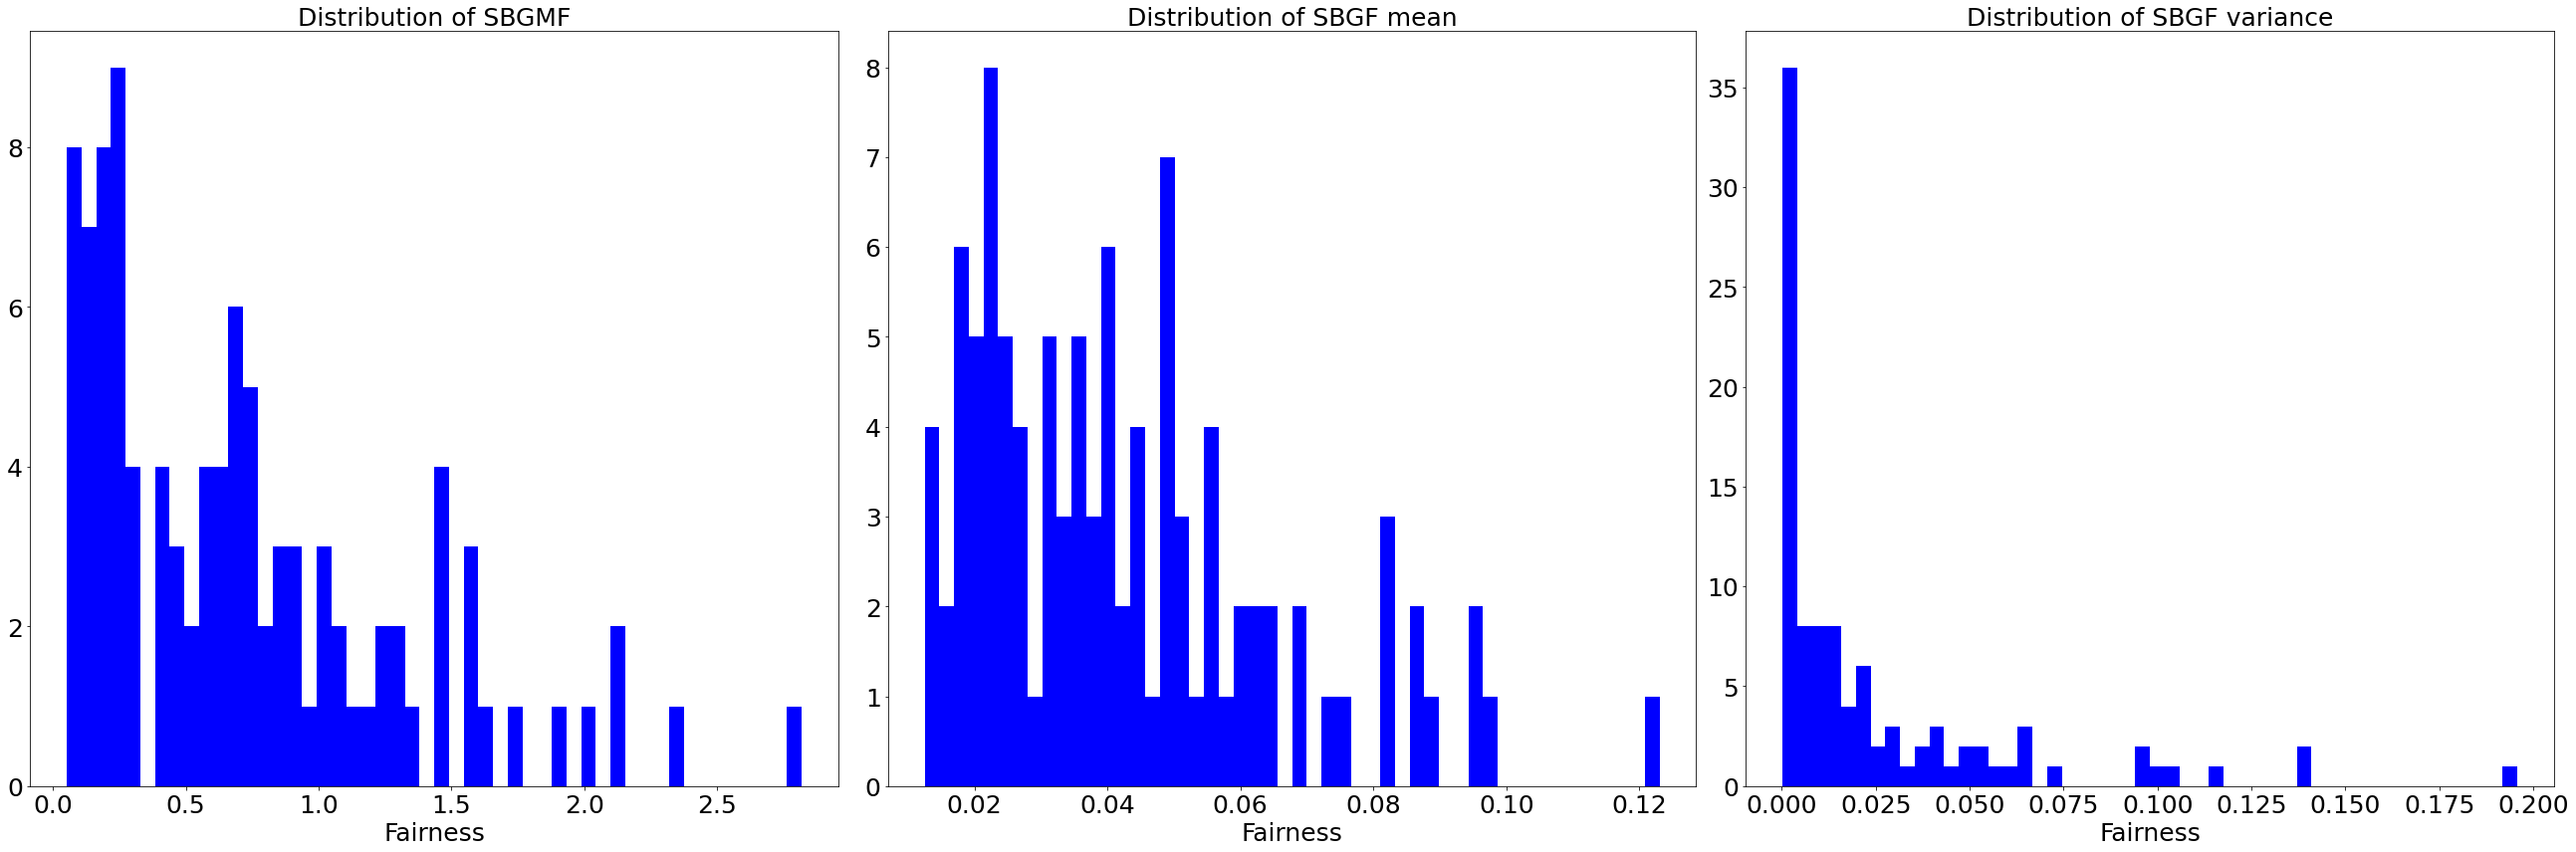

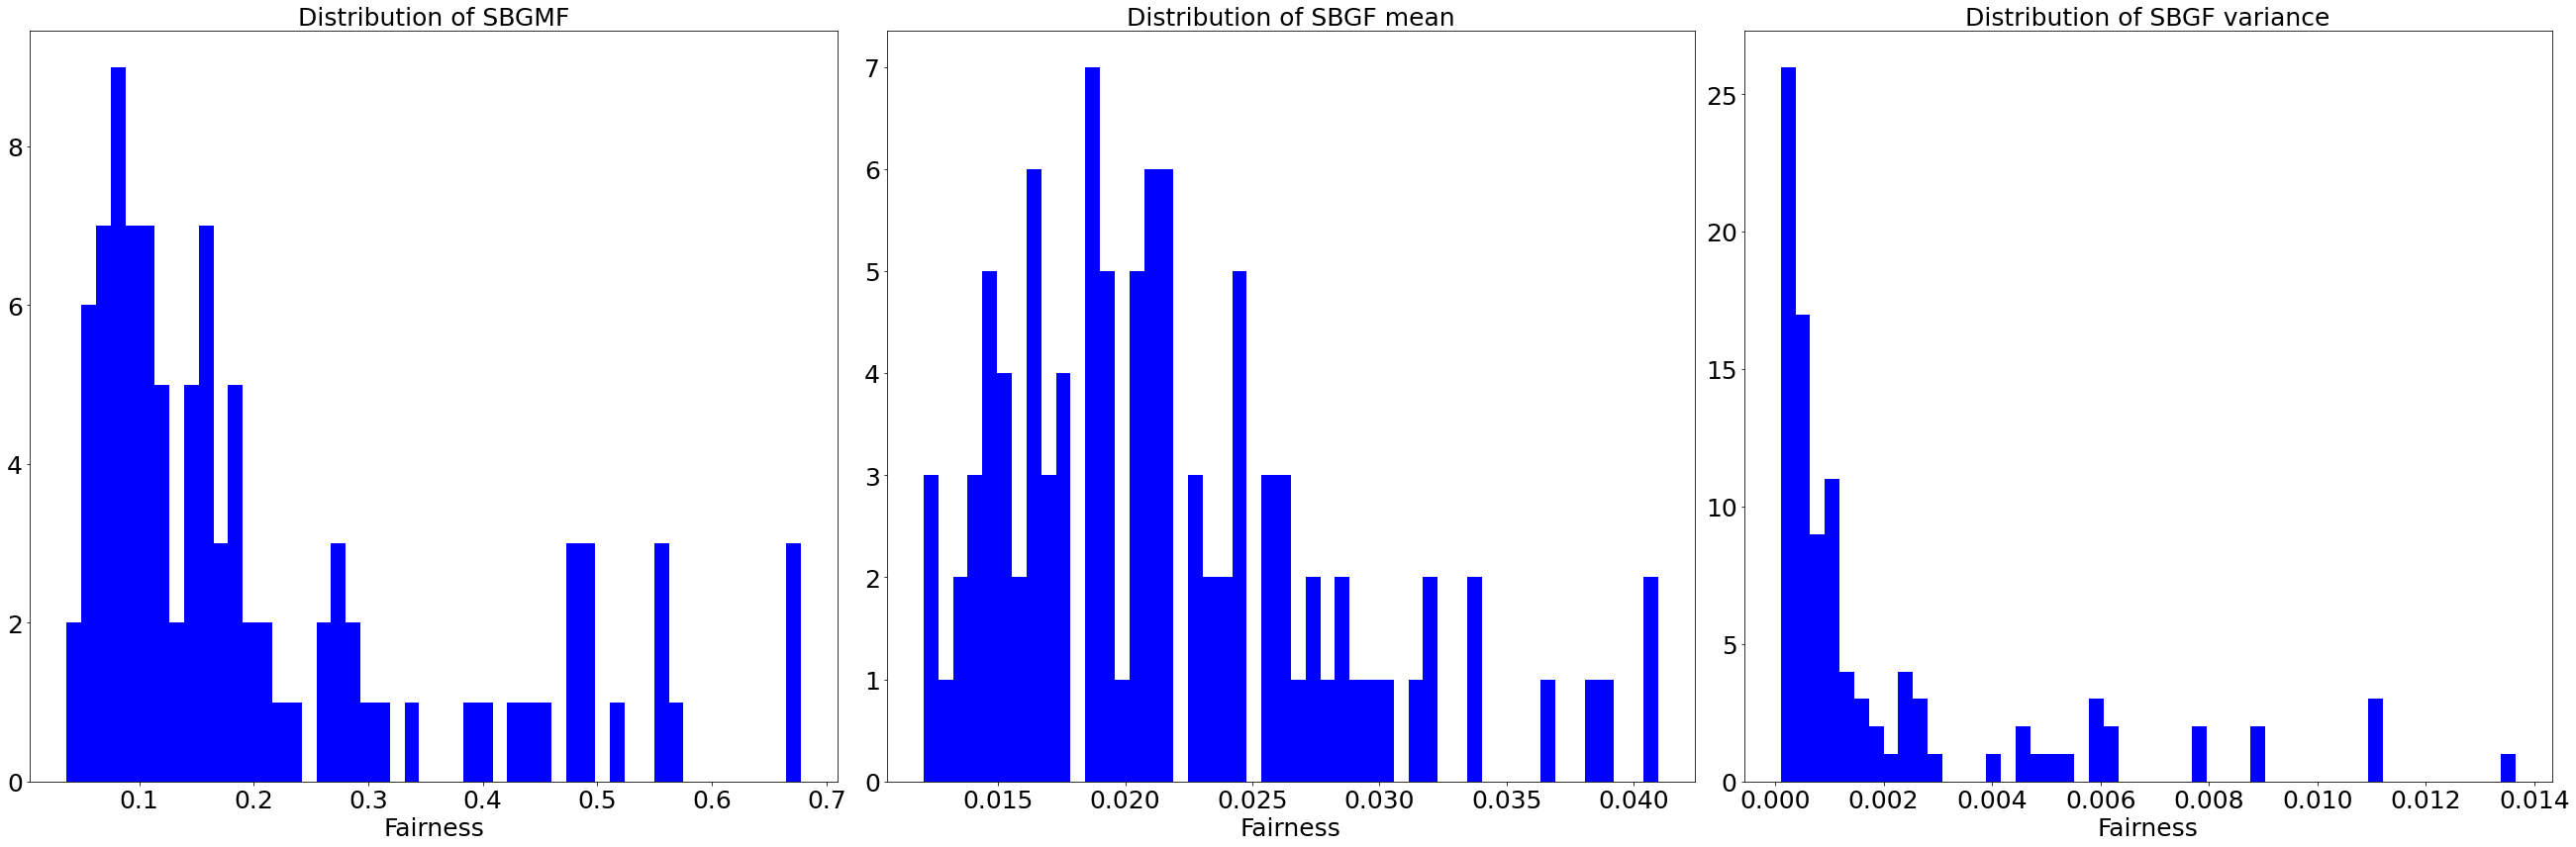

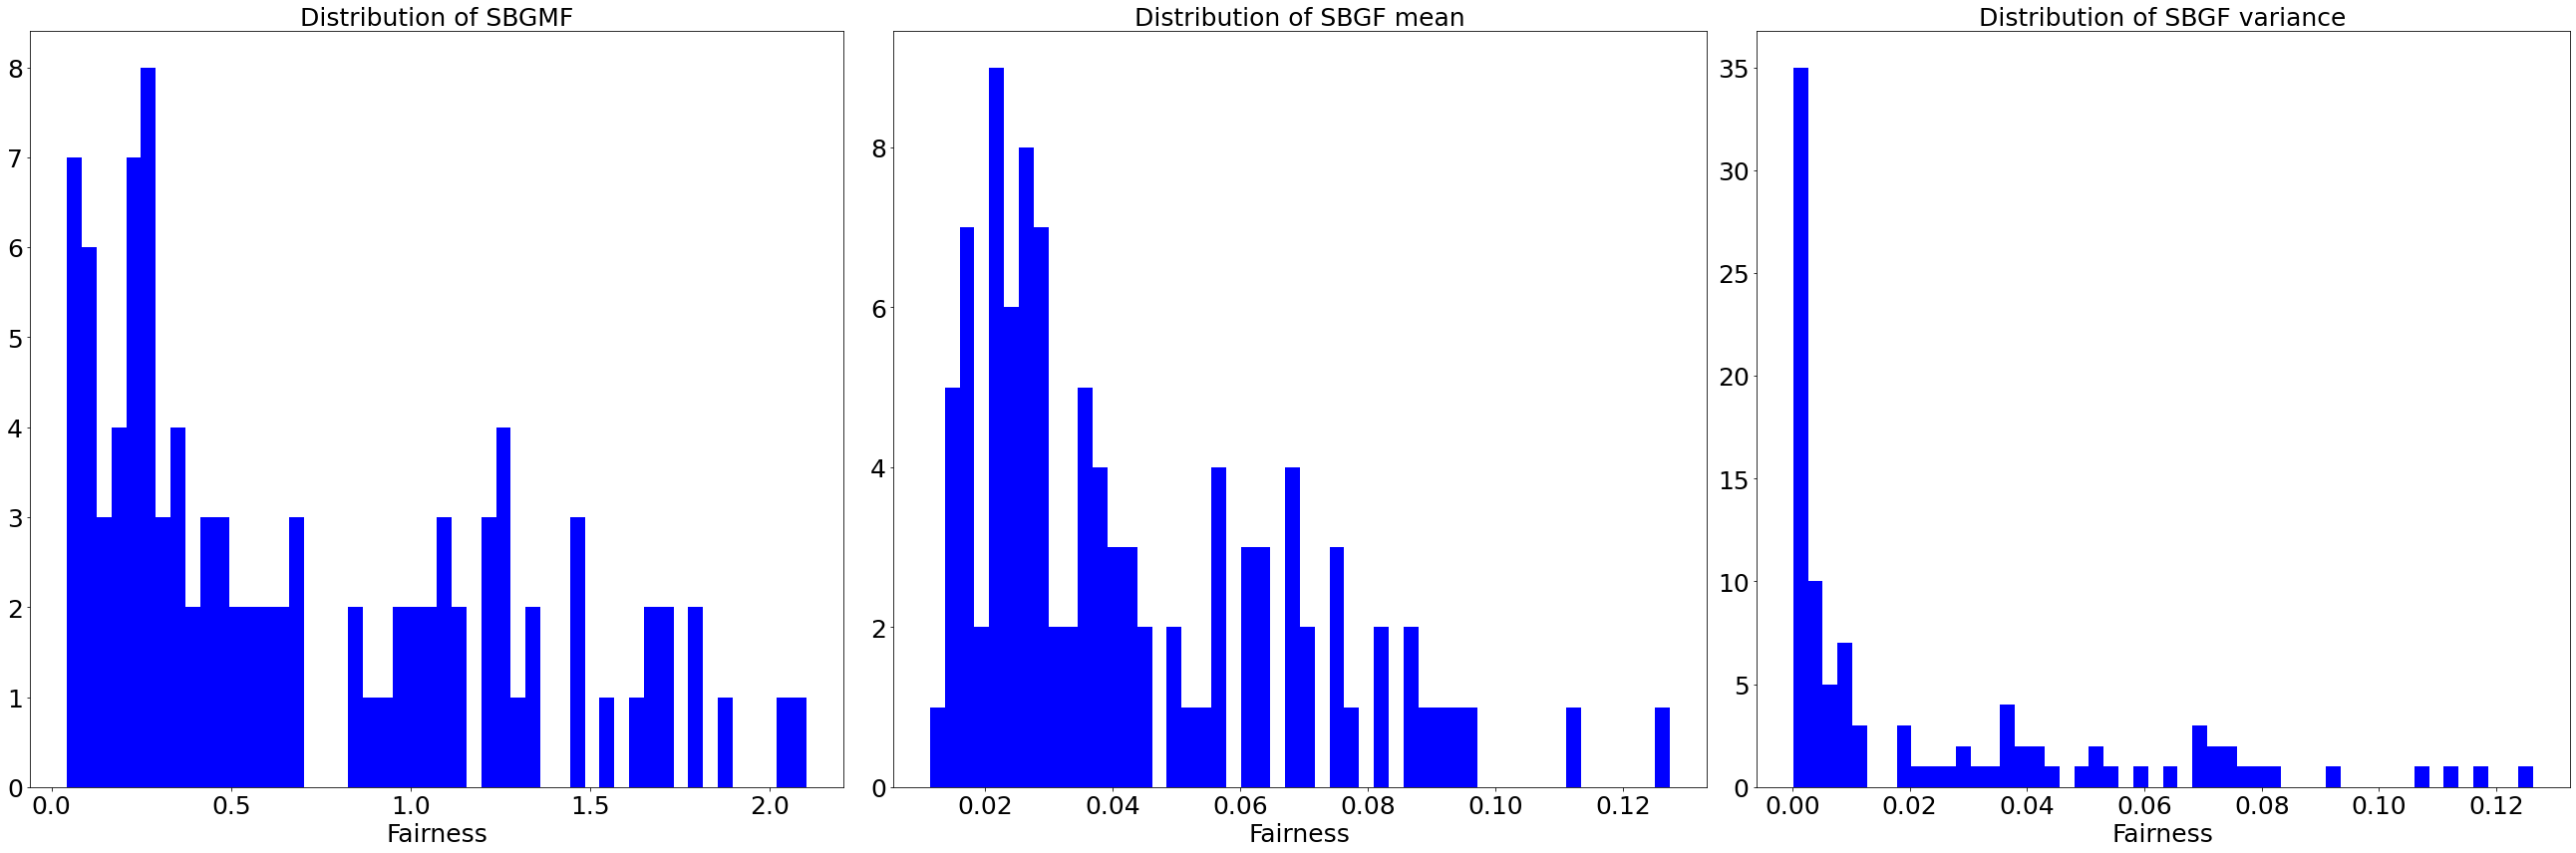

In [199]:
# generate plots of histograms of GF, AF and SBGF_Var
def generate_histogram(GF, AF, SBGF_Var, method):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(36,12))

    axs[0].hist(GF, bins=50, color='blue')
    axs[0].set_title('Distribution of SBGMF', fontsize=25)
    axs[0].set_xlabel('Fairness', fontsize=25)
    axs[0].tick_params(axis='x', labelsize=25)
    axs[0].tick_params(axis='y', labelsize=25)

    axs[1].hist(AF, bins=50, color='blue')
    axs[1].set_title('Distribution of SBGF mean', fontsize=25)
    axs[1].set_xlabel('Fairness', fontsize=25)
    axs[1].tick_params(axis='x', labelsize=25)
    axs[1].tick_params(axis='y', labelsize=25)

    axs[2].hist(SBGF_Var, bins=50, color='blue')
    axs[2].set_title('Distribution of SBGF variance', fontsize=25)
    axs[2].set_xlabel('Fairness', fontsize=25)
    axs[2].tick_params(axis='x', labelsize=25)
    axs[2].tick_params(axis='y', labelsize=25)

    fig.tight_layout()
    # fig.suptitle('Fairness Distribution using Kmeans', fontsize=16)
    # plt.subplots_adjust(top=0.5)
    
    plt.savefig('./Results/Histograms of Method_' + method, dpi=500, bbox_inches='tight', facecolor='white')

generate_histogram(Kmeans_GF, Kmeans_AF, Kmeans_SBGF_Var, "K-means")
generate_histogram(Agg_GF, Agg_AF, Agg_SBGF_Var, "AGG")
generate_histogram(BKPP_GF, BKPP_AF, BKPP_SBGF_Var, "BKPP")

## Bar charts of all methods comparing GF

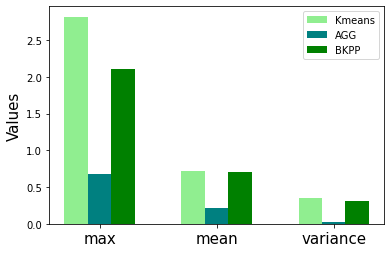

In [197]:

def generate_bar(Kmeans, AGG, BKPP):
    # Set the positions of the bars on the x-axis
    x_pos = np.arange(3)

    # Set the width of each bar
    width = 0.2

    # Create the figure and axis objects
    fig, ax = plt.subplots()

    # Create the three sets of bars
    ax.bar(x_pos - width, Kmeans, width, color='#90EE90', label='Kmeans')
    ax.bar(x_pos, AGG, width, color='teal', label='AGG')
    ax.bar(x_pos + width, BKPP, width, color='green', label='BKPP')

    # Add labels and a legend
    # ax.set_xlabel('Numbers')
    ax.set_ylabel('Values', fontsize=15)
    # ax.set_title('Max')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['max', 'mean', 'variance'], fontsize=15)
    ax.legend()

    plt.savefig('./Results/Bar chart of attributes of SBGMF of all Methods', dpi=500, bbox_inches='tight', facecolor='white')

Data_Kmeans = [Kmeans_overall_max, Kmeans_overall_mean, Kmeans_GF_Var]
Data_Agg = [Agg_overall_max, Agg_overall_mean, Agg_GF_Var]
Data_BKPP = [BKPP_overall_max, BKPP_overall_mean, BKPP_GF_Var]

generate_bar(Data_Kmeans, Data_Agg, Data_BKPP)

## QQ-plots

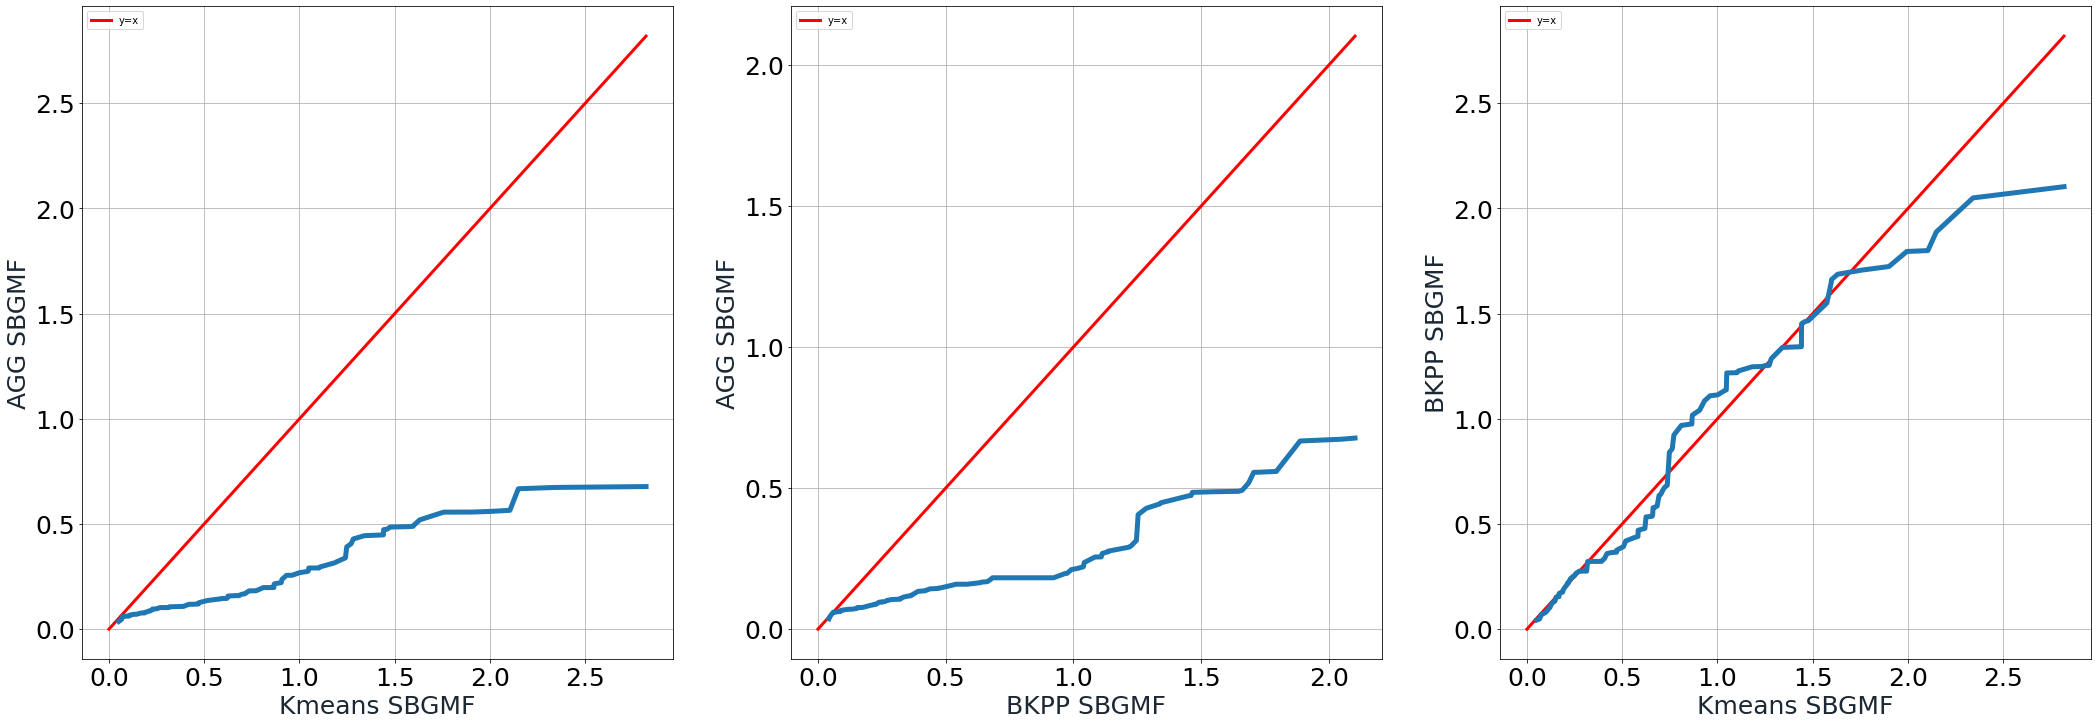

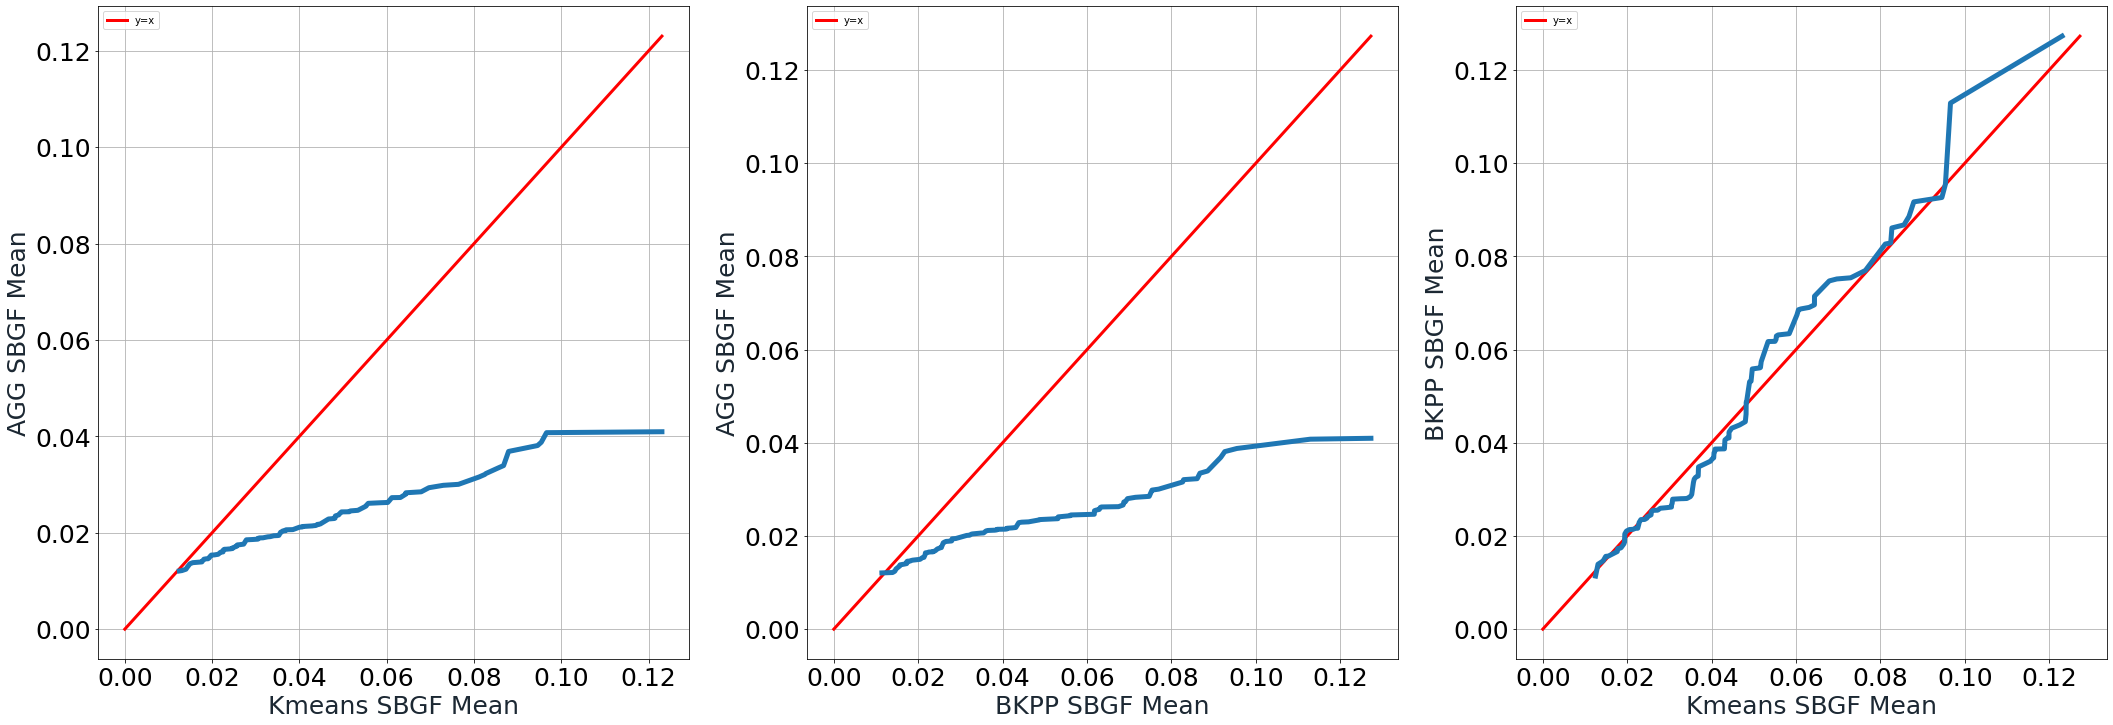

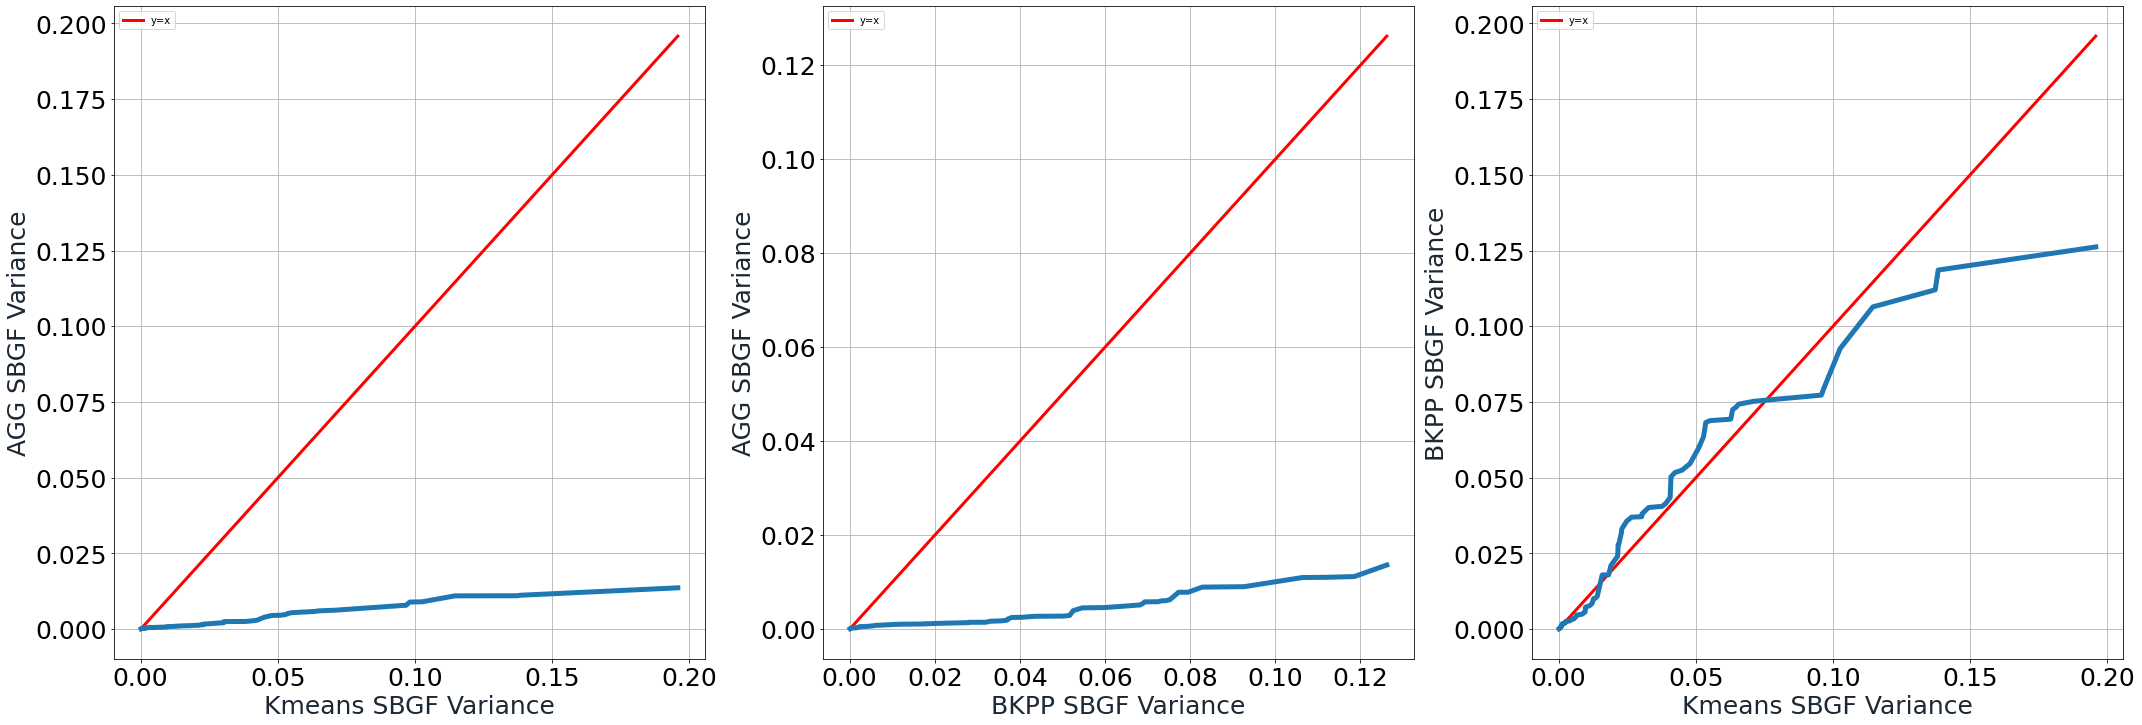

In [198]:
def qq_plot(Kmeans, AGG, BKPP, attribute):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(36,12))

    s_Kmeans = sorted(Kmeans)
    s_AGG = sorted(AGG)
    s_BKPP = sorted(BKPP)

    # Kmeans & AGG
    m = np.max([np.max(Kmeans), np.max(AGG)])
    x = np.linspace(0,m,100)
    y = x
    axs[0].plot(x, y, '-r',linewidth=3, label='y=x')
    axs[0].set_xlabel('Kmeans ' + attribute, color='#1C2833', fontsize=25)
    axs[0].set_ylabel('AGG ' + attribute, color='#1C2833', fontsize=25)
    axs[0].legend(loc='upper left')
    axs[0].grid()
    lst1 = s_Kmeans
    lst2 = s_AGG
    axs[0].plot(lst1,lst2, linewidth=5)
    axs[0].tick_params(axis='x', labelsize=25)
    axs[0].tick_params(axis='y', labelsize=25)

    # BKPP & AGG
    m = np.max([np.max(BKPP), np.max(AGG)])
    x = np.linspace(0,m,100)
    y = x
    axs[1].plot(x, y, '-r',linewidth=3, label='y=x')
    axs[1].set_xlabel('BKPP ' + attribute, color='#1C2833', fontsize=25)
    axs[1].set_ylabel('AGG ' + attribute, color='#1C2833', fontsize=25)
    axs[1].legend(loc='upper left')
    axs[1].grid()
    lst1 = s_BKPP
    lst2 = s_AGG
    axs[1].plot(lst1,lst2, linewidth=5)
    axs[1].tick_params(axis='x', labelsize=25)
    axs[1].tick_params(axis='y', labelsize=25)

    # Kmean & BKPP
    m = np.max([np.max(Kmeans), np.max(BKPP)])
    x = np.linspace(0,m,100)
    y = x
    axs[2].plot(x, y, '-r',linewidth=3, label='y=x')
    axs[2].set_xlabel('Kmeans ' + attribute, color='#1C2833', fontsize=25)
    axs[2].set_ylabel('BKPP ' + attribute, color='#1C2833', fontsize=25)
    axs[2].legend(loc='upper left')
    axs[2].grid()
    lst1 = s_Kmeans
    lst2 = s_BKPP
    axs[2].plot(lst1,lst2, linewidth=5)
    axs[2].tick_params(axis='x', labelsize=25)
    axs[2].tick_params(axis='y', labelsize=25)
    
    plt.savefig('./Results/QQ_plot_' + attribute, dpi=500, bbox_inches='tight', facecolor='white')


qq_plot(Kmeans_GF, Agg_GF, BKPP_GF, "SBGMF")
qq_plot(Kmeans_AF, Agg_AF, BKPP_AF, "SBGF Mean")
qq_plot(Kmeans_SBGF_Var, Agg_SBGF_Var, BKPP_SBGF_Var, "SBGF Variance")
